In [1]:
#### import libraries

#import pandas_datareader as web
import os
import pandas as pd
import numpy as np
import datetime as dt
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as web
import pypfopt
from pypfopt import risk_models
from pypfopt import expected_returns

C:\Users\pbala\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
#### import data

stocks = ['AMZN','TSLA','FB','GOOGL','AAPL','NFLX']
data = web.DataReader(stocks, 'yahoo',start='2016-1-1',end='2020-5-5')
prices = data['Adj Close']

In [3]:
returns = prices.loc[dt.datetime(2016,1,1):dt.datetime(2020,6,1)].groupby(pd.Grouper(freq='M')).head(1).pct_change()
sum_corr = returns.corr().sum().sort_values(ascending=True).index.values
correlation = returns.corr()


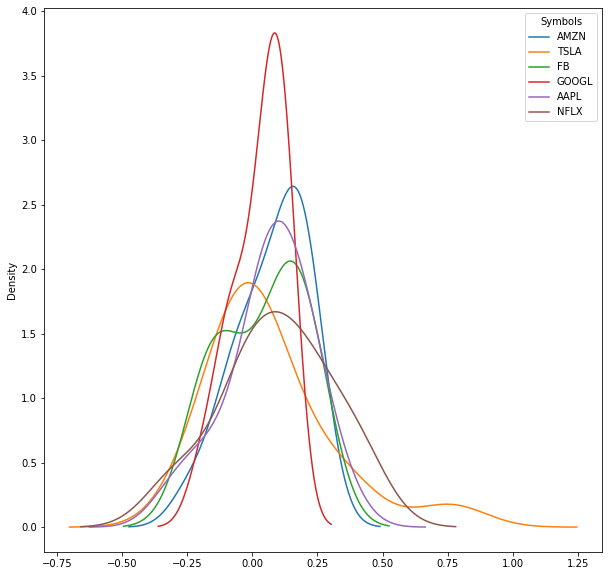

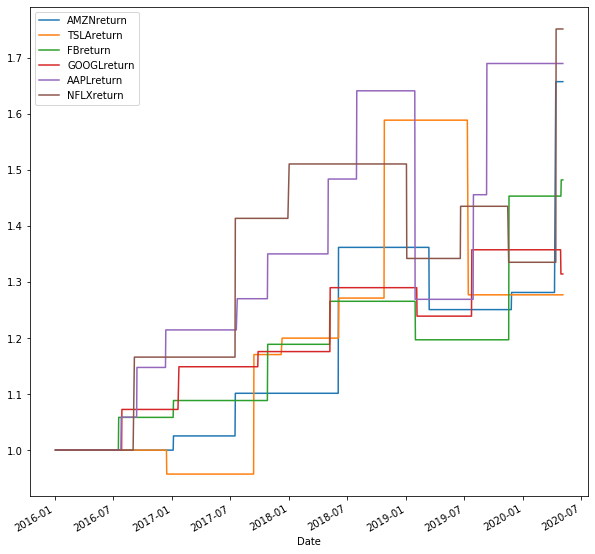

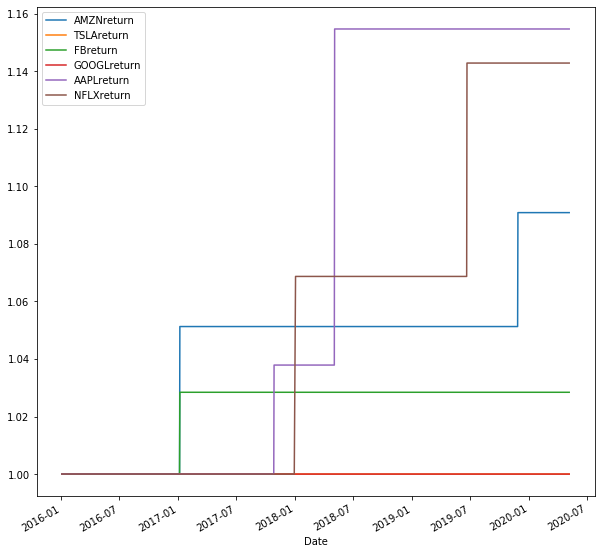

In [10]:
from scipy.ndimage.interpolation import shift

strategy = prices.copy()
returns = pd.DataFrame(columns=stocks, index=strategy.index)

strategy2 = prices.copy()
returns2 = pd.DataFrame(columns=stocks, index=strategy2.index)

benchmark = prices.copy()


for i in strategy.columns: 
    newvector = np.where(strategy[i].values > strategy[i].rolling(30).mean() + strategy[i].rolling(30).std() * 2,-1,
             np.where(strategy[i].values < strategy[i].rolling(30).mean() - strategy[i].rolling(30).std() * 2,1,np.NaN))
    temp = pd.DataFrame(newvector).fillna(method='ffill').values
    #strategy[i+'mean'] = strategy[i].rolling(30).mean()
    #strategy[i+'sd'] = strategy[i].rolling(30).std()
    strategy[i+'p'] = np.asarray([l[0] if l != temp[i - 1] else np.NaN for i, l in enumerate(temp)])
    temp2 = strategy.drop(strategy.loc[strategy[i+'p'].isna()].index)
    temp2[i+'return'] = temp2[i].pct_change()[1:]
    temp3 = temp2.loc[temp2[i+'p']== -1,i+'return']
    returns = pd.merge(returns,temp3, how='left',left_index=True, right_index=True)
   
for i in strategy2.columns: 
    newvector = np.where(strategy2[i].rolling(5).mean() < strategy2[i].rolling(40).mean() ,-1,
             np.where(strategy2[i].rolling(5).mean() > strategy2[i].rolling(40).mean(),1,np.NaN))
    temp = pd.DataFrame(newvector).fillna(method='ffill').values
    strategy2[i+'p'] = np.asarray([l[0] if l != temp[i - 1] else np.NaN for i, l in enumerate(temp)])
    temp2 = strategy.drop(strategy2.loc[strategy2[i+'p'].isna()].index)
    temp2[i+'return'] = temp2[i].pct_change()[1:]
    temp3 = temp2.loc[temp2[i+'p']== -1,i+'return']
    returns2 = pd.merge(returns2,temp3, how='left',left_index=True, right_index=True)
    
    
benchmark = prices.dropna().groupby(pd.Grouper(freq='Q')).head(1).pct_change().dropna()

returns.dropna(how='all').to_csv('prova2.csv',sep=';',float_format='%.2f')
#returns.iloc[:,len(stocks):].dropna(how='all').plot(kind='density',figsize=(10,10))
benchmark.plot(kind='density',figsize=(10,10))
(returns.iloc[:,len(stocks):].fillna(0).apply(lambda x: x+1)).cumprod().plot(figsize=(10,10))
(returns2.iloc[:,len(stocks):].fillna(0).apply(lambda x: x+1)).cumprod().plot(figsize=(10,10))
returns = returns.iloc[:,len(stocks):]
returns2 = returns2.iloc[:,len(stocks):]

In [12]:
#### financial functions
def value_at_risk(x, lab_return='ret', confidence_level=.05):
    return x[lab_return].quantile(confidence_level, interpolation='higher')

def expected_shortfall(x, lab_return='ret', confidence_level=.05):
    var = value_at_risk(x, lab_return, confidence_level)
    return x[lab_return][x[lab_return].lt(var)].mean()

def volatility(x, lab_return='ret'):
    return x[lab_return].std()

def Sharpe_Ratio(x,lab_return='ret',rf=0):
    mean_avg_daily_rets = (x[lab_return] - rf).mean()
    vol = volatility(x,lab_return=lab_return)
    sharpe_ratio = (mean_avg_daily_rets/vol)
    return sharpe_ratio

def sortino_ratio(x,lab_return='ret',rf=0):
    expected_return = x[lab_return].mean()
    down_stdev = x.loc[x[lab_return] < 0, lab_return].dropna().std()
    sortino_ratio = (expected_return - rf)/down_stdev
    return sortino_ratio

def stamptodate(x): 
    from datetime import datetime
    import numpy as np
    ts = (x - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    return datetime.utcfromtimestamp(ts)

def average_year_return(x,lab_return='ret'):
    start_date = stamptodate(min(x[lab_return].index))
    end_date = stamptodate(max(x[lab_return].index))
    difference_in_years = (end_date.year - start_date.year)
    return (x[lab_return].dropna()+1).cumprod().tail(1)**(1/difference_in_years)-1

py = pd.DataFrame(returns.dropna(how='all').fillna(0).mean(axis=1),columns=['port'])
py2 = pd.DataFrame(returns2.dropna(how='all').fillna(0).mean(axis=1),columns=['port'])
port = np.array([float(py['port'].mean()),
                   float(average_year_return(py,lab_return='port')),
                   float(volatility(py,lab_return='port')),
                   float(Sharpe_Ratio(py,lab_return='port')),
                   float(sortino_ratio(py,lab_return='port')),
                   float(value_at_risk(py,lab_return='port')),
                   float(expected_shortfall(x=py, lab_return='port' , confidence_level=.05)),
                                 float(len(py['port'].dropna()))])

avg = np.array(np.NaN)
avg2 = np.array(np.NaN)
bench = np.array(np.NaN)


for i in returns.columns:
    avg = np.append(avg,np.array([float(returns[i].mean()),
                   float(average_year_return(returns,lab_return=i)),
                   float(volatility(returns,lab_return=i)),
                   float(Sharpe_Ratio(returns,lab_return=i)),
                   float(sortino_ratio(returns,lab_return=i)),
                   float(value_at_risk(returns,lab_return=i)),
                   float(expected_shortfall(x=returns, lab_return=i , confidence_level=.05)),
                                 float(len(returns[i].dropna()))]))

    
for i in benchmark.columns:   
    bench = np.append(bench,np.array([float(benchmark[i].mean()),
                   float(average_year_return(benchmark,lab_return=i)),
                   float(volatility(benchmark,lab_return=i)),
                   float(Sharpe_Ratio(benchmark,lab_return=i)),
                   float(sortino_ratio(benchmark,lab_return=i)),
                   float(value_at_risk(benchmark,lab_return=i)),
                   float(expected_shortfall(x=benchmark, lab_return=i , confidence_level=.05)),
                                 float(len(benchmark[i].dropna()))]))
    

KPIs = avg[1:].reshape(len(stocks),8).transpose()
#KPIs2 = avg2[1:].reshape(len(stocks),8).transpose()
KPIb = bench[1:].reshape(len(stocks),8).transpose()


a = pd.DataFrame(KPIs,columns=stocks,
             index = ['av_return','Yearly_returns','Volatility','Sharpe_ratio','Sortino_Ratio','VAR','ES','no_operations'])
#a2 = pd.DataFrame(KPIs2,columns=stocks,
 #            index = ['av_return','Yearly_returns','Volatility','Sharpe_ratio','Sortino_Ratio','VAR','ES','no_operations'])
b = pd.DataFrame(KPIb,columns=stocks,
             index = ['av_return','Yearly_returns','Volatility','Sharpe_ratio','Sortino_Ratio','VAR','ES','no_operations'])
c = pd.Series(port,
             index = ['av_return','Yearly_returns','Volatility','Sharpe_ratio','Sortino_Ratio','VAR','ES','no_operations'])
print(a)
#print(a2)
print(b)
print(c)
print(a-b)





                    AMZN      TSLA        FB     GOOGL       AAPL      NFLX
av_return       0.095417  0.053041  0.060491  0.041222   0.059610  0.092426
Yearly_returns  0.134672  0.063063  0.103389  0.070720   0.140175  0.150426
Volatility      0.142037  0.167120  0.082180  0.057864   0.107701  0.151064
Sharpe_ratio    0.671774  0.317384  0.736083  0.712394   0.553473  0.611832
Sortino_Ratio        NaN  0.488764       NaN  7.723252        NaN  3.111484
VAR             0.024472 -0.042736  0.019878 -0.031840   0.045867 -0.069617
ES             -0.081559 -0.196208 -0.054295 -0.039388  -0.226735 -0.111625
no_operations   6.000000  6.000000  7.000000  7.000000  10.000000  7.000000
                     AMZN       TSLA         FB      GOOGL       AAPL  \
av_return        0.075538   0.067893   0.039105   0.027103   0.067183   
Yearly_returns   0.315511   0.211677   0.117826   0.097569   0.251471   
Volatility       0.137586   0.239265   0.163200   0.101116   0.163933   
Sharpe_ratio     0.54902

C:\Users\pbala\anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


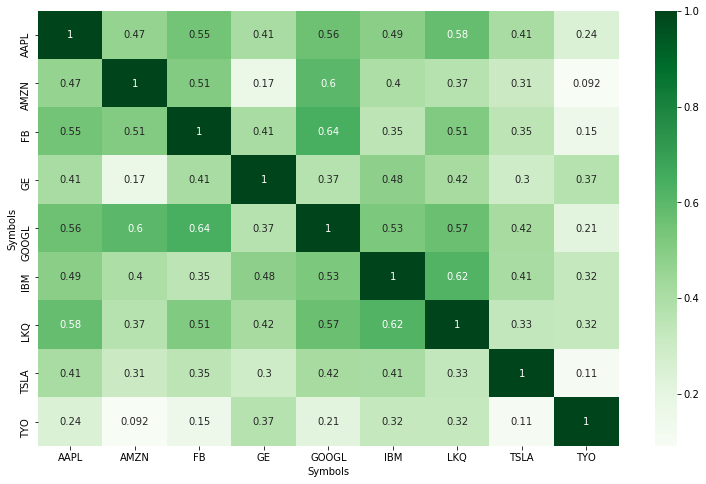

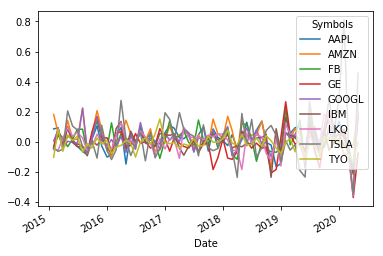

In [45]:
plt.figure(figsize=(13, 8))
sns.heatmap(correlation, annot=True, cmap='Greens');returns.plot()


In [99]:
from datetime import datetime 
import pandas_datareader as web 
import pandas as pd 
import numpy as np 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


df = web.DataReader('AAPL', 'yahoo', '2010-01-01', '2020-06-05') 

prices= df['Adj Close']

week = prices.groupby([pd.Grouper(freq='W')]).last().pct_change() 

def difference(dataDf, period): 
    return dataDf.sub(dataDf.shift(period), fill_value=np.NaN) 

def ewm(dataDf, halflife): 
    return dataDf.ewm(halflife=halflife, ignore_na=False, min_periods=0, adjust=True).mean() 

def rsi(data, period): 
    data_upside = data.sub(data.shift(1), fill_value=0) 
    data_downside = data_upside.copy() 
    data_downside[data_upside > 0] = 0 
    data_upside[data_upside < 0] = 0 
    avg_upside = data_upside.rolling(period).mean() 
    avg_downside = - data_downside.rolling(period).mean() 
    rsi = 100 - (100 * avg_downside / (avg_downside + avg_upside)) 
    rsi[avg_downside == 0] = 100 
    rsi[(avg_downside == 0) & (avg_upside == 0)] = 0 
    return rsi 

  

def create_features(data, freq='W'): 
    period = data.groupby([pd.Grouper(freq=freq)]).last() 
    basis_X = pd.DataFrame(index = period.index, columns =  []) 
    
    basis_X['perc1'] = (prices.pct_change()>0).groupby([pd.Grouper(freq='W')]).mean()
    basis_X['perc2'] = (prices.pct_change()>0).groupby([pd.Grouper(freq='W')]).mean().shift(1)
    basis_X['perc3'] = (prices.pct_change()>0).groupby([pd.Grouper(freq='W')]).mean().shift(2)
    basis_X['perc4'] = (prices.pct_change()>0).groupby([pd.Grouper(freq='W')]).mean().shift(3) 
    basis_X['perc5'] = (prices.pct_change()>0).groupby([pd.Grouper(freq='W')]).mean().shift(4)
    basis_X['perc6'] = (prices.pct_change()>0).groupby([pd.Grouper(freq='W')]).mean().shift(5)
    basis_X['perc7'] = (prices.pct_change()>0).groupby([pd.Grouper(freq='W')]).mean().shift(6)
    basis_X['perc8'] = (prices.pct_change()>0).groupby([pd.Grouper(freq='W')]).mean().shift(7)
    basis_X['perc9'] = (prices.pct_change()>0).groupby([pd.Grouper(freq='W')]).mean().shift(8) 
    basis_X['perc10'] = (prices.pct_change()>0).groupby([pd.Grouper(freq='W')]).mean().shift(9)
    
    basis_X['pct1'] = period.pct_change()
    basis_X['pct2'] = period.pct_change().shift(1)
    basis_X['pct3'] = period.pct_change().shift(2) 
    basis_X['pct4'] = period.pct_change().shift(3) 
    basis_X['pct5'] = period.pct_change().shift(4) 
    basis_X['pct10'] = period.pct_change().shift(9) 
    
    basis_X['lag1'] = period
    basis_X['lag2'] = period.shift(1)
    basis_X['lag3'] = period.shift(2) 
    basis_X['lag4'] = period.shift(3) 
    basis_X['lag5'] = period.shift(4) 
    basis_X['lag10'] = period.shift(10) 
    
    basis_X['mom1'] = difference(period,1)
    basis_X['mom4'] = difference(period,4)
    basis_X['mom6'] = difference(period,6)
    basis_X['mom8'] = difference(period,8) 
    basis_X['mom10'] = difference(period,12)

    basis_X['sd11'] = data.groupby([pd.Grouper(freq=freq)]).std().diff(1)
    basis_X['sd41'] = data.groupby([pd.Grouper(freq=freq)]).std().diff(4)
    basis_X['sd61'] = data.groupby([pd.Grouper(freq=freq)]).std().diff(6)
    basis_X['sd81'] = data.groupby([pd.Grouper(freq=freq)]).std().diff(8)
    basis_X['sd121'] = data.groupby([pd.Grouper(freq=freq)]).std().diff(12)
    
    basis_X['sd12'] = data.groupby([pd.Grouper(freq=freq)]).std().diff(1).shift(1)
    basis_X['sd42'] = data.groupby([pd.Grouper(freq=freq)]).std().diff(4).shift(1)
    basis_X['sd62'] = data.groupby([pd.Grouper(freq=freq)]).std().diff(6).shift(1)
    basis_X['sd82'] = data.groupby([pd.Grouper(freq=freq)]).std().diff(8).shift(1) 
    basis_X['sd122'] = data.groupby([pd.Grouper(freq=freq)]).std().diff(12).shift(1) 
    
    basis_X['sd13'] = data.groupby([pd.Grouper(freq=freq)]).std().diff(1).shift(2)
    basis_X['sd43'] = data.groupby([pd.Grouper(freq=freq)]).std().diff(4).shift(2)
    basis_X['sd63'] = data.groupby([pd.Grouper(freq=freq)]).std().diff(6).shift(2)
    basis_X['sd83'] = data.groupby([pd.Grouper(freq=freq)]).std().diff(8).shift(2) 
    basis_X['sd123'] = data.groupby([pd.Grouper(freq=freq)]).std().diff(12).shift(2) 

    basis_X['rsi4'] = rsi(data,4).groupby([pd.Grouper(freq=freq)]).last()
    basis_X['rsi6'] = rsi(data,6).groupby([pd.Grouper(freq=freq)]).last() 
    basis_X['rsi12'] = rsi(data,12).groupby([pd.Grouper(freq=freq)]).last()
    
    basis_X['emadata3'] = ewm(period,3)
    basis_X['emadata4'] = ewm(period,4)
    basis_X['emadata6'] = ewm(period,6)
    basis_X['emadata8'] = ewm(period,8)
    
    basis_X['emadata31'] = ewm(period,3).shift(1)
    basis_X['emadata41'] = ewm(period,4).shift(1)
    basis_X['emadata61'] = ewm(period,6).shift(1)
    basis_X['emadata81'] = ewm(period,8).shift(1)
    
    basis_X['emadata32'] = ewm(period,3).shift(2)
    basis_X['emadata42'] = ewm(period,4).shift(2)
    basis_X['emadata62'] = ewm(period,6).shift(2)
    basis_X['emadata82'] = ewm(period,8).shift(2)
    
    basis_X['emadata34'] = ewm(period,3).shift(4)
    basis_X['emadata44'] = ewm(period,4).shift(4)
    basis_X['emadata64'] = ewm(period,6).shift(4)
    basis_X['emadata84'] = ewm(period,8).shift(4)
    
    basis_X['emabasis3'] = ewm(period,3).pct_change(1)
    basis_X['emabasis4'] = ewm(period,4).pct_change(4)
    basis_X['emabasis6'] = ewm(period,6).pct_change(6)
    basis_X['emabasis8'] = ewm(period,8).pct_change(8)
    
    basis_X['emabasis32'] = ewm(period,3).pct_change(1).shift(1)
    basis_X['emabasis42'] = ewm(period,4).pct_change(4).shift(1)
    basis_X['emabasis62'] = ewm(period,6).pct_change(6).shift(1) 
    basis_X['emabasis82'] = ewm(period,8).pct_change(8).shift(1)
    
    basis_X['emabasis33'] = ewm(period,3).pct_change(1).shift(2)
    basis_X['emabasis43'] = ewm(period,4).pct_change(4).shift(2)
    basis_X['emabasis63'] = ewm(period,6).pct_change(6).shift(2) 
    basis_X['emabasis83'] = ewm(period,8).pct_change(8).shift(2)
    
    basis_X['target'] = period.pct_change().shift(-1)
    back = basis_X.dropna()

    X = back.drop(['target'], axis=1) 
    y = back['target'] 
    return X, y 


def create_features_daily(data):  
    basis_X = pd.DataFrame(index = data.index, columns =  []) 
    
    basis_X['perc1'] = data.pct_change()>0
    basis_X['perc2'] = (data.pct_change()>0).shift(1)
    basis_X['perc3'] = (data.pct_change()>0).shift(2)
    basis_X['perc4'] = (data.pct_change()>0).shift(3) 
    basis_X['perc5'] = (data.pct_change()>0).shift(4)
    basis_X['perc6'] = (data.pct_change()>0).shift(5)
    basis_X['perc7'] = (data.pct_change()>0).shift(6)
    basis_X['perc8'] = (data.pct_change()>0).shift(7)
    basis_X['perc9'] = (data.pct_change()>0).shift(8) 
    basis_X['perc10'] = (data.pct_change()>0).shift(9)
    
    basis_X['lag1'] = data
    basis_X['lag2'] = (data).shift(1)
    basis_X['lag3'] = (data).shift(2)
    basis_X['lag4'] = (data).shift(3) 
    basis_X['lag5'] = (data).shift(4)
    basis_X['lag6'] = (data).shift(5)
    basis_X['lag7'] = (data).shift(6)
    basis_X['lag8'] = (data).shift(7)
    basis_X['lag9'] = (data).shift(8) 
    basis_X['lag10'] = (data).shift(9)
    
    #basis_X['mom1'] = difference(data.pct_change(),1)
    #basis_X['mom4'] = difference(data.pct_change(),4)
    #basis_X['mom6'] = difference(data.pct_change(),6)
    #basis_X['mom8'] = difference(data.pct_change(),8) 
    #basis_X['mom10'] = difference(data.pct_change(),12)

    basis_X['sd11'] = data.rolling(5).std().diff(1)
    basis_X['sd41'] = data.rolling(5).std().diff(4)
    basis_X['sd61'] = data.rolling(5).std().diff(6)
    basis_X['sd81'] = data.rolling(5).std().diff(8)
    basis_X['sd121'] = data.rolling(5).std().diff(12)
    
    basis_X['sd12'] = data.rolling(3).std().diff(1).shift(1)
    basis_X['sd42'] = data.rolling(3).std().diff(4).shift(1)
    basis_X['sd62'] = data.rolling(3).std().diff(6).shift(1)
    basis_X['sd82'] = data.rolling(3).std().diff(8).shift(1) 
    basis_X['sd122'] = data.rolling(3).std().diff(12).shift(1) 
    
    basis_X['sd13'] = data.rolling(3).std().diff(1).shift(2)
    basis_X['sd43'] = data.rolling(3).std().diff(4).shift(2)
    basis_X['sd63'] = data.rolling(3).std().diff(6).shift(2)
    basis_X['sd83'] = data.rolling(3).std().diff(8).shift(2) 
    basis_X['sd123'] = data.rolling(3).std().diff(12).shift(2) 

    basis_X['rsi4'] = rsi(data,4)
    basis_X['rsi6'] = rsi(data,6)
    basis_X['rsi12'] = rsi(data,12)
    
    basis_X['emadata3'] = ewm(data,3)
    basis_X['emadata4'] = ewm(data,4)
    basis_X['emadata6'] = ewm(data,6)
    basis_X['emadata8'] = ewm(data,8)
    
    basis_X['emadata31'] = ewm(data,3).shift(1)
    basis_X['emadata41'] = ewm(data,4).shift(1)
    basis_X['emadata61'] = ewm(data,6).shift(1)
    basis_X['emadata81'] = ewm(data,8).shift(1)
    
    basis_X['emadata32'] = ewm(data,3).shift(2)
    basis_X['emadata42'] = ewm(data,4).shift(2)
    basis_X['emadata62'] = ewm(data,6).shift(2)
    basis_X['emadata82'] = ewm(data,8).shift(2)
    
    basis_X['emadata34'] = ewm(data,3).shift(4)
    basis_X['emadata44'] = ewm(data,4).shift(4)
    basis_X['emadata64'] = ewm(data,6).shift(4)
    basis_X['emadata84'] = ewm(data,8).shift(4)
    
    basis_X['emabasis3'] = ewm(data,3).pct_change(1)
    basis_X['emabasis4'] = ewm(data,4).pct_change(4)
    basis_X['emabasis6'] = ewm(data,6).pct_change(6)
    basis_X['emabasis8'] = ewm(data,8).pct_change(8)
    
    basis_X['emabasis32'] = ewm(data,3).pct_change(1).shift(1)
    basis_X['emabasis42'] = ewm(data,4).pct_change(4).shift(1)
    basis_X['emabasis62'] = ewm(data,6).pct_change(6).shift(1) 
    basis_X['emabasis82'] = ewm(data,8).pct_change(8).shift(1)
    
    basis_X['emabasis33'] = ewm(data,3).pct_change(1).shift(2)
    basis_X['emabasis43'] = ewm(data,4).pct_change(4).shift(2)
    basis_X['emabasis63'] = ewm(data,6).pct_change(6).shift(2) 
    basis_X['emabasis83'] = ewm(data,8).pct_change(8).shift(2)
    
    basis_X['target'] = data.shift(-1)
    back = basis_X.dropna()

    X = back.drop(['target'], axis=1) 
    y = back['target'] 
    return X, y 


def create_features_daily2(data):  
    basis_X = pd.DataFrame(index = data.index, columns =  []) 
    
    basis_X['perc1'] = data.pct_change()>0
    basis_X['perc2'] = (data.pct_change()>0).shift(1)
    basis_X['perc3'] = (data.pct_change()>0).shift(2)
    basis_X['perc4'] = (data.pct_change()>0).shift(3) 
    basis_X['perc5'] = (data.pct_change()>0).shift(4)
    basis_X['perc6'] = (data.pct_change()>0).shift(5)
    basis_X['perc7'] = (data.pct_change()>0).shift(6)
    basis_X['perc8'] = (data.pct_change()>0).shift(7)
    basis_X['perc9'] = (data.pct_change()>0).shift(8) 
    basis_X['perc10'] = (data.pct_change()>0).shift(9)
    
    basis_X['lag1'] = data
    basis_X['lag2'] = (data).shift(1)
    basis_X['lag3'] = (data).shift(2)
    basis_X['lag4'] = (data).shift(3) 
    basis_X['lag5'] = (data).shift(4)
    basis_X['lag6'] = (data).shift(5)
    basis_X['lag7'] = (data).shift(6)
    basis_X['lag8'] = (data).shift(7)
    basis_X['lag9'] = (data).shift(8) 
    basis_X['lag10'] = (data).shift(9)

    basis_X['sd11'] = data.rolling(5).std().diff(1)
    basis_X['sd41'] = data.rolling(5).std().diff(4)
    basis_X['sd61'] = data.rolling(5).std().diff(6)
    basis_X['sd81'] = data.rolling(5).std().diff(8)
    basis_X['sd121'] = data.rolling(5).std().diff(12)
    
    basis_X['sd30'] = data < data.rolling(30).mean() - 2 * data.rolling(30).std()
    basis_X['sd301'] = (data < data.rolling(30).mean() - 2 * data.rolling(30).std()).shift(1)
    basis_X['sd10'] = data < data.rolling(10).mean() - 2 * data.rolling(10).std()
    basis_X['sd101'] = (data < data.rolling(10).mean() - 2 * data.rolling(10).std()).shift(1)
    
    basis_X['sd12'] = data.rolling(3).std().diff(1).shift(1)
    basis_X['sd42'] = data.rolling(3).std().diff(4).shift(1)
    basis_X['sd62'] = data.rolling(3).std().diff(6).shift(1)
    basis_X['sd82'] = data.rolling(3).std().diff(8).shift(1) 
    basis_X['sd122'] = data.rolling(3).std().diff(12).shift(1) 
    
    basis_X['sd13'] = data.rolling(3).std().diff(1).shift(2)
    basis_X['sd43'] = data.rolling(3).std().diff(4).shift(2)
    basis_X['sd63'] = data.rolling(3).std().diff(6).shift(2)
    basis_X['sd83'] = data.rolling(3).std().diff(8).shift(2) 
    basis_X['sd123'] = data.rolling(3).std().diff(12).shift(2) 

    basis_X['rsi4'] = rsi(data,4)
    basis_X['rsi6'] = rsi(data,6)
    basis_X['rsi12'] = rsi(data,12)
    
    basis_X['emadata3'] = ewm(data,3)
    basis_X['emadata4'] = ewm(data,4)
    basis_X['emadata6'] = ewm(data,6)
    basis_X['emadata8'] = ewm(data,8)
    
    basis_X['emadata31'] = ewm(data,3).shift(1)
    basis_X['emadata41'] = ewm(data,4).shift(1)
    basis_X['emadata61'] = ewm(data,6).shift(1)
    basis_X['emadata81'] = ewm(data,8).shift(1)
    
    basis_X['emadata32'] = ewm(data,3).shift(2)
    basis_X['emadata42'] = ewm(data,4).shift(2)
    basis_X['emadata62'] = ewm(data,6).shift(2)
    basis_X['emadata82'] = ewm(data,8).shift(2)
    
    basis_X['emadata34'] = ewm(data,3).shift(4)
    basis_X['emadata44'] = ewm(data,4).shift(4)
    basis_X['emadata64'] = ewm(data,6).shift(4)
    basis_X['emadata84'] = ewm(data,8).shift(4)
    
    basis_X['emabasis3'] = ewm(data,3).pct_change(1)
    basis_X['emabasis4'] = ewm(data,4).pct_change(4)
    basis_X['emabasis6'] = ewm(data,6).pct_change(6)
    basis_X['emabasis8'] = ewm(data,8).pct_change(8)
    
    basis_X['emabasis32'] = ewm(data,3).pct_change(1).shift(1)
    basis_X['emabasis42'] = ewm(data,4).pct_change(4).shift(1)
    basis_X['emabasis62'] = ewm(data,6).pct_change(6).shift(1) 
    basis_X['emabasis82'] = ewm(data,8).pct_change(8).shift(1)
    
    basis_X['emabasis33'] = ewm(data,3).pct_change(1).shift(2)
    basis_X['emabasis43'] = ewm(data,4).pct_change(4).shift(2)
    basis_X['emabasis63'] = ewm(data,6).pct_change(6).shift(2) 
    basis_X['emabasis83'] = ewm(data,8).pct_change(8).shift(2)
    
    basis_X['target'] = data.pct_change().shift(-1)
    back = basis_X.dropna()

    X = back.drop(['target'], axis=1) 
    y = back['target'] 
    return X, y 


X, y = create_features_daily2(prices) 

valdata = datetime(2019,6,30) 

X_val = X.loc[valdata:] 
y_val = y.loc[valdata:]


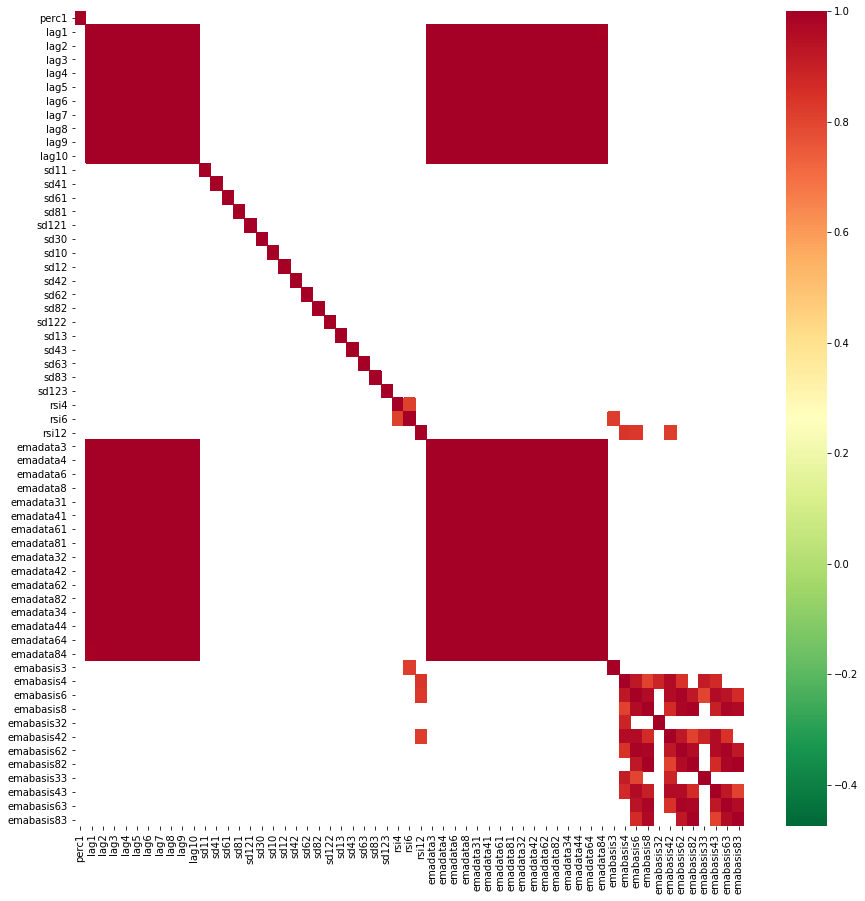

              precision    recall  f1-score   support

       False       0.47      0.45      0.46       372
        True       0.52      0.54      0.53       411

    accuracy                           0.50       783
   macro avg       0.49      0.49      0.49       783
weighted avg       0.50      0.50      0.50       783

              precision    recall  f1-score   support

       False       0.46      0.34      0.39       372
        True       0.52      0.64      0.57       411

    accuracy                           0.50       783
   macro avg       0.49      0.49      0.48       783
weighted avg       0.49      0.50      0.48       783

              precision    recall  f1-score   support

       False       0.45      0.43      0.44       372
        True       0.51      0.53      0.52       411

    accuracy                           0.48       783
   macro avg       0.48      0.48      0.48       783
weighted avg       0.48      0.48      0.48       783

              preci

In [105]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X.loc[:valdata], y.loc[:valdata], test_size=0.33, random_state=25) 

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)
  

import seaborn 
c = X.corr() 
plt.figure(figsize=(15,15)) 
seaborn.heatmap(c, cmap='RdYlGn_r', mask = (np.abs(c) <= 0.8)) 
plt.show() 


from sklearn import neighbors 
n_neighbors = 5 
model = neighbors.KNeighborsClassifier(n_neighbors, weights='distance') 
model.fit(X_train_norm, y_train>.0) 
basis_y_pred = model.predict(X_test_norm) 
basis_y_knn = basis_y_pred.copy() 

from sklearn.svm import SVC 
modelS = SVC(kernel='rbf', C=1e3, gamma=0.1) 
modelS.fit(X_train_norm, y_train>.0) 
basis_y_pred = modelS.predict(X_test_norm) 
basis_y_svr = basis_y_pred.copy() 

from sklearn import ensemble 
model=ensemble.ExtraTreesClassifier() 
model.fit(X_train_norm, y_train>.0) 
basis_y_pred = model.predict(X_test_norm) 
basis_y_trees = basis_y_pred.copy() 

from sklearn.linear_model import SGDClassifier
model = SGDClassifier(
              early_stopping=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=500,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
model.fit(X_train_norm, y_train>.0) 
basis_y_pred = model.predict(X_test_norm) 
basis_y_sdg = basis_y_pred.copy() 

from sklearn.metrics import classification_report 
print(classification_report(y_test>.0, basis_y_knn)) 
print(classification_report(y_test>.0, basis_y_svr)) 
print(classification_report(y_test>.0, basis_y_trees)) 
print(classification_report(y_test>.0, basis_y_sdg)) 


from sklearn.metrics import confusion_matrix 
print(confusion_matrix(y_test>.0, basis_y_knn)) 
print(confusion_matrix(y_test>.0, basis_y_svr)) 
print(confusion_matrix(y_test>.0, basis_y_trees)) 
print(confusion_matrix(y_test>.0, basis_y_sdg)) 


-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:   40.4s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   40.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.0s finished


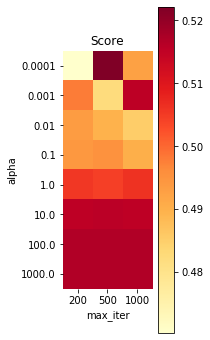

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=500,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False) 0.5222026259063296


In [70]:
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import parfit.parfit as pf
from sklearn.metrics import roc_curve, auc



def plot_roc_auc(actual, preds):
    fpr, tpr, thresholds = roc_curve(actual, preds[:,1])
    plt.plot(fpr, tpr,'r')
    plt.plot([0,1],[0,1],'b')
    plt.title('AUC: {}'.format(auc(fpr,tpr)))
    plt.show()

    


grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'max_iter': [200,500,1000], # number of epochs
    'loss': ['log'], # logistic regression,
    'penalty': ['l2']
    #,
   # 'n_jobs': [-1]
}

paramGrid = ParameterGrid(grid)
bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier, paramGrid,
           X_train_norm, y_train>0, X_test_norm, y_test>0, metric = roc_auc_score)

print(bestModel, bestScore)

In [106]:
X_val_norm = scaler.transform(X_val)
modelS.predict(X_val_norm)
print((X_val))
np.where(modelS.predict(X_val_norm),-1,1)

print(X_val.iloc[:,10].shift(-1))
y_val



            perc1  perc2  perc3  perc4  perc5  perc6  perc7  perc8  perc9  \
Date                                                                        
2019-07-01   True  False  False   True  False  False  False   True  False   
2019-07-02   True   True  False  False   True  False  False  False   True   
2019-07-03   True   True   True  False  False   True  False  False  False   
2019-07-05  False   True   True   True  False  False   True  False  False   
2019-07-08  False  False   True   True   True  False  False   True  False   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2020-05-15  False   True  False  False   True   True   True   True   True   
2020-05-18   True  False   True  False  False   True   True   True   True   
2020-05-19  False   True  False   True  False  False   True   True   True   
2020-05-20   True  False   True  False   True  False  False   True   True   
2020-05-21  False   True  False   True  False   True  False  False   True   

Date
2019-07-01    0.005855
2019-07-02    0.008287
2019-07-03   -0.000881
2019-07-05   -0.020614
2019-07-08    0.006099
                ...   
2020-05-15    0.023561
2020-05-18   -0.005778
2020-05-19    0.019448
2020-05-20   -0.007455
2020-05-21    0.006438
Name: target, Length: 226, dtype: float64

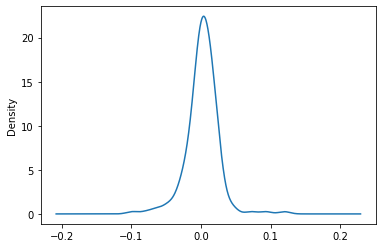

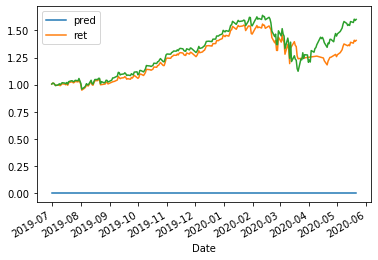

In [127]:
x = prices.loc[valdata:].pct_change().shift(-1).dropna()
returns3 = pd.DataFrame(data=x.values,columns=['GOOGL'], index=x.index)

newvector = np.where(model.predict(X_val_norm),-1,1)
temp = pd.DataFrame(newvector).fillna(method='ffill').values
returns3['ret'] = np.asarray([l[0] if l != temp[i - 1] else np.NaN for i, l in enumerate(temp)])


#temp2 = returns3.dropna().drop(returns3.loc[returns3.ret==-1].index)
#(1+temp2.GOOGL).cumprod().plot()
    #temp3 = temp2.loc[temp2[i+'p']== -1,i+'return']
    #returns2 = pd.merge(returns2,temp3, how='left',left_index=True, right_index=True)
    
return4 = pd.DataFrame({'pred':np.where(model.predict(X_val_norm),-1,1),
'ret': y_val})

return4[ return4.pred== -1].ret.plot(kind='density')
(1 + return4[ return4.pred== -1]).cumprod().plot()
(1 + y_val).cumprod().plot()

In [ ]:
#### backtesting+ 

  

import backtester 

from backtester.features.feature import Feature 

from backtester.trading_system import TradingSystem 

from backtester.sample_scripts.fair_value_params import FairValueTradingParams 

class Problem1Solver(): 

def getTrainingDataSet(self): 

        return "trainingData1" 

def getSymbolsToTrade(self): 

        return ['MQK'] 

def getCustomFeatures(self): 

        return {'my_custom_feature': MyCustomFeature} 

def getFeatureConfigDicts(self): 

                             

        expma5dic = {'featureKey': 'emabasis5', 

                 'featureId': 'exponential_moving_average', 

                 'params': {'period': 5, 

                              'featureName': 'basis'}} 

        expma10dic = {'featureKey': 'emabasis10', 

                 'featureId': 'exponential_moving_average', 

                 'params': {'period': 10, 

                              'featureName': 'basis'}}                      

        expma2dic = {'featureKey': 'emabasis3', 

                 'featureId': 'exponential_moving_average', 

                 'params': {'period': 3, 

                              'featureName': 'basis'}} 

        mom10dic = {'featureKey': 'mom10', 

                 'featureId': 'difference', 

                 'params': {'period': 11, 

                              'featureName': 'basis'}} 

         

        return [expma5dic,expma2dic,expma10dic,mom10dic]     

     

    def getFairValue(self, updateNum, time, instrumentManager): 

        # holder for all the instrument features 

        lbInstF = instrumentManager.getlookbackInstrumentFeatures() 

        mom10 = lbInstF.getFeatureDf('mom10').iloc[-1] 

        emabasis2 = lbInstF.getFeatureDf('emabasis2').iloc[-1] 

        emabasis5 = lbInstF.getFeatureDf('emabasis5').iloc[-1] 

        emabasis10 = lbInstF.getFeatureDf('emabasis10').iloc[-1]  

        basis = lbInstF.getFeatureDf('basis').iloc[-1] 

        totalaskvol = lbInstF.getFeatureDf('stockTotalAskVol').iloc[-1] - lbInstF.getFeatureDf('futureTotalAskVol').iloc[-1] 

        totalbidvol = lbInstF.getFeatureDf('stockTotalBidVol').iloc[-1] - lbInstF.getFeatureDf('futureTotalBidVol').iloc[-1] 

         

        coeff = [ 0.03249183, 0.49675487, -0.22289464, 0.2025182, 0.5080227, -0.21557005, 0.17128488] 

        newdf['MQK'] = coeff[0] * mom10['MQK'] + coeff[1] * emabasis2['MQK'] +\ 

                      coeff[2] * emabasis5['MQK'] + coeff[3] * emabasis10['MQK'] +\ 

                      coeff[4] * basis['MQK'] + coeff[5] * totalaskvol['MQK']+\ 

                      coeff[6] * totalbidvol['MQK'] 

                     

        newdf.fillna(emabasis5,inplace=True) 

        return newdf 

problem1Solver = Problem1Solver() 

tsParams = FairValueTradingParams(problem1Solver) 

tradingSystem = TradingSystem(tsParams) 

tradingSystem.startTrading(onlyAnalyze=False,  

                           shouldPlot=True, 

                           makeInstrumentCsvs=False) 
